# Exercise
The exercise will attempt to convey important skills and concepts in applying data science in a production environment.
- Thinking about the data
 - what is it like and what could I do with it?
 - what is the business objective?
- Generating value from ML:
 - establishing a baseline
 - improving as required
 

## The challange that you have been set:
You are part of a fast growing social media startup HypeVentures that provides chat and discussion space technology to other startup to improve the customer engagement with the content the users post. Management has hired you to sort out their marketing messaging as the last marketing guy quit and they intend to hire a bunch of different topic experts to deal with the different forums.
 

- what do people talk about?
 1. Can we cluster the conversation topics?
 2. Can we label some of them by hand?
 3. Use that to label the rest?
- Classify some new incomming data?

## Lessons learnt
- Humble pie
 - unlabled data is hard (unsupervised learning)
 - human labeling is extremely valuable
 - Always check your work
- Curse of dimensionality 

## Next steps
- get the data labeled [Amazon SageMaker](https://aws.amazon.com/sagemaker/groundtruth/pricing/)
- Can we train a classifer?

In [1]:
import sklearn
sklearn.__version__


'0.21.2'

In [2]:
# Imports we'll need
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from exercise_utils import plot_confusion_matrix, get_bank_data


In [3]:
# Sklean features
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

Data ingress
load '1_data.csv' into a pandas dataframe and inspect it

In [4]:
#df2 = pd.read_csv('data_alt.atheism_soc.religion.christian_categories_train.csv')
df2 = pd.read_csv('data_comp.graphics_sci.med_categories_train.csv').dropna()
df2_test = pd.read_csv('data_comp.graphics_sci.med_categories_test.csv').dropna()
df2.head()

subject                                               data       category
0        0  Hi,\n\nwell I have opened up a FTP site for ge...  comp.graphics
1        1  \nIt isn't that rare, actually.  Many cases th...        sci.med
2        0  \n\nThe equation of the sphere through the 4 p...  comp.graphics
3        1  Thanks to all those who responded to my origin...        sci.med
5        1  \nCandida albicans can cause severe life-threa...        sci.med

Vecotrize the text data 

1. Either using a counting vectorizer 
2. or a hashing one

Using english default stop words:
stop words are words like: and, to, I etc. Complete list for a common usecase: https://gist.github.com/sebleier/554280

In [5]:
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(df2.data)

In [6]:
# Transform the data
svd = TruncatedSVD(n_components=40)
X_reduced = svd.fit_transform(X_train_counts)

norm = Normalizer()
X = norm.fit_transform(X_reduced)

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

In [8]:
X += abs(X.min())

In [9]:
clfb = SGDClassifier(tol=None,random_state=0, max_iter=5).fit(X, df2.subject)

In [10]:
targets = df2.groupby('subject')['category'].first().sort_index().tolist()

In [11]:
clfb

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
docs_new = ['OpenGL on the GPU is fast','This disease is dangerous']

X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = svd.transform(X_new_counts)
predicted = clfb.predict(X_new_tfidf)

In [13]:
predicted

array([0, 1], dtype=int64)

In [14]:
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, targets[category]))

'OpenGL on the GPU is fast' => comp.graphics
'This disease is dangerous' => sci.med


In [15]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

In [16]:
text_clf.fit(df2.data, df2.subject)  

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [17]:
text_clf.score(df2_test.data, df2_test.subject)

0.9505208333333334

In [42]:
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([
   ('vect', CountVectorizer(stop_words='english')),
   ('tfidf', TfidfTransformer()),
   ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                         max_iter=50, tol=None)),
])

In [19]:
text_clf.fit(df2.data, df2.subject)  

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabular...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [20]:
text_clf.score(df2_test.data, df2_test.subject) 


0.94140625

In [21]:
predicted = text_clf.predict(df2_test.data)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(df2_test.subject, predicted,
    target_names=targets))

               precision    recall  f1-score   support

comp.graphics       0.95      0.93      0.94       384
      sci.med       0.93      0.95      0.94       384

     accuracy                           0.94       768
    macro avg       0.94      0.94      0.94       768
 weighted avg       0.94      0.94      0.94       768



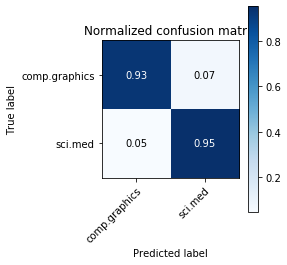

In [23]:
cm = confusion_matrix(df2_test.subject, predicted)
plot_confusion_matrix(df2_test.subject, predicted,targets,
                          normalize=True)
plt.show()

## Bonus material
With more difficult data or more and different data 

In [24]:
#file = lambda x: f'data_all_categories_{x}.csv'
#file = lambda x: f'data_alt.atheism_soc.religion.christian_categories_{x}.csv'
file = lambda x: f'data_comp.graphics_sci.med_alt.atheism_soc.religion.christian_categories_{x}.csv'
df = pd.read_csv(file('train')).dropna()
df_test = pd.read_csv(file('test')).dropna()
df.head()

subject                                               data  \
0        3  \nJohn, \n\nWhile I will not take the time to ...   
1        3  \n\nGifts of the Spirit should not be seen as ...   
2        2  \n\nI recall reading in the recently revised e...   
3        3  [deletia- sig]\n\n[deletia- formalities]\n\nI ...   
4        0  \n\nYou misrepresent me, Selim.  The hard evid...   

                 category  
0  soc.religion.christian  
1  soc.religion.christian  
2                 sci.med  
3  soc.religion.christian  
4             alt.atheism

In [25]:
X_train = df.data
y_train = df.subject

targets = df.groupby('subject')['category'].first().sort_index().tolist()
X_test = df_test.data
y_test = df_test.subject

                        precision    recall  f1-score   support

           alt.atheism       0.79      0.56      0.66       313
         comp.graphics       0.86      0.96      0.91       384
               sci.med       0.88      0.89      0.89       384
soc.religion.christian       0.79      0.88      0.83       387

              accuracy                           0.84      1468
             macro avg       0.83      0.82      0.82      1468
          weighted avg       0.83      0.84      0.83      1468



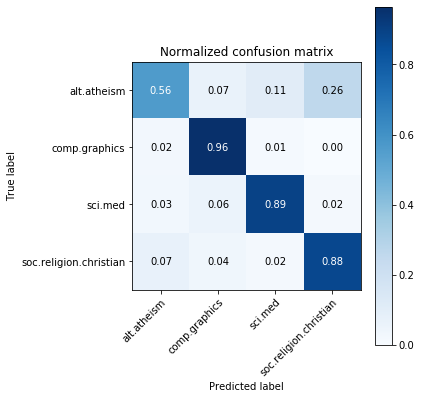

In [26]:
text_clf.fit(X_train, y_train)  
y_pred = text_clf.predict(X_test)

print(classification_report(y_test, y_pred,
    target_names=targets))
plot_confusion_matrix(y_test, y_pred,targets,
                          normalize=True)
plt.show()

## More bonus material

In [27]:
from sklearn.model_selection import train_test_split
df = get_bank_data().head(10000)
df.head()

C:\Users\rum\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (4,5,6,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


category  \
463  Credit reporting, credit repair services, or o...   
815  Credit reporting, credit repair services, or o...   
833                                    Debt collection   
863                                    Debt collection   
893  Credit reporting, credit repair services, or o...   

                                                  data  subject  
463  XXXX XXXX breached duty of care. XX/XX/2019 RE...        6  
815  In 2011 I filed a chapter XXXX bankruptcy and ...        6  
833  ACCOUNT RECOVERY SERVICE XXXX {$450.00} I was ...        7  
863  Credit Management Opened XXXX XXXX, 2012 {$430...        7  
893  I am a victim of identity theft. I have filed ...        6

In [28]:
targets = df.groupby('subject')['category'].first().sort_index().tolist()
targets

['Checking or savings account',
 'Credit card or prepaid card',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Debt collection',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Student loan',
 'Vehicle loan or lease']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df.data, df.subject)

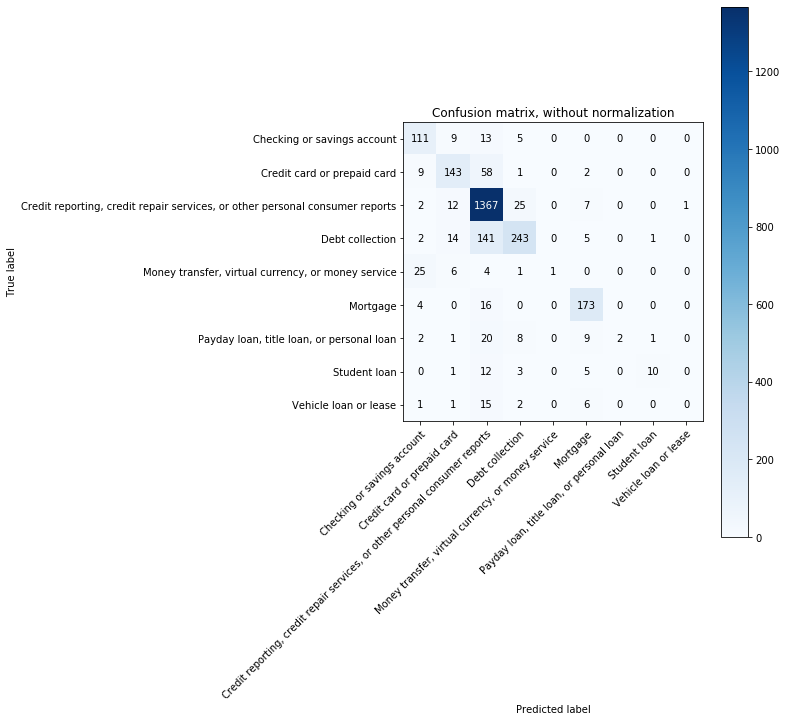

In [44]:
text_clf.fit(X_train, y_train)  
y_pred = text_clf.predict(X_test)


plot_confusion_matrix(y_test, y_pred,targets,
                          normalize=False)
plt.show()

In [45]:
#Let's add some better stopwords to see if we can improve things
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(['XX','XXX', 'XXXX'])
text_clf.set_params(vect__stop_words=stop_words)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=frozenset({'XX', 'XXX', 'XXXX', 'a',
                                                       'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_

In [47]:
print(classification_report(y_test, y_pred, target_names=targets))

                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.71      0.80      0.76       138
                                                 Credit card or prepaid card       0.76      0.67      0.71       213
Credit reporting, credit repair services, or other personal consumer reports       0.83      0.97      0.89      1414
                                                             Debt collection       0.84      0.60      0.70       406
                          Money transfer, virtual currency, or money service       1.00      0.03      0.05        37
                                                                    Mortgage       0.84      0.90      0.86       193
                                   Payday loan, title loan, or personal loan       1.00      0.05      0.09        43
                                                       

In [48]:
from sklearn.metrics import accuracy_score, f1_score
print(f'Testing accuracy {accuracy_score(y_test, y_pred):.2%}')
print(f"Testing F1 score: {f1_score(y_test, y_pred, average='weighted'):.2%}" )

Testing accuracy 82.00%
Testing F1 score: 79.65%


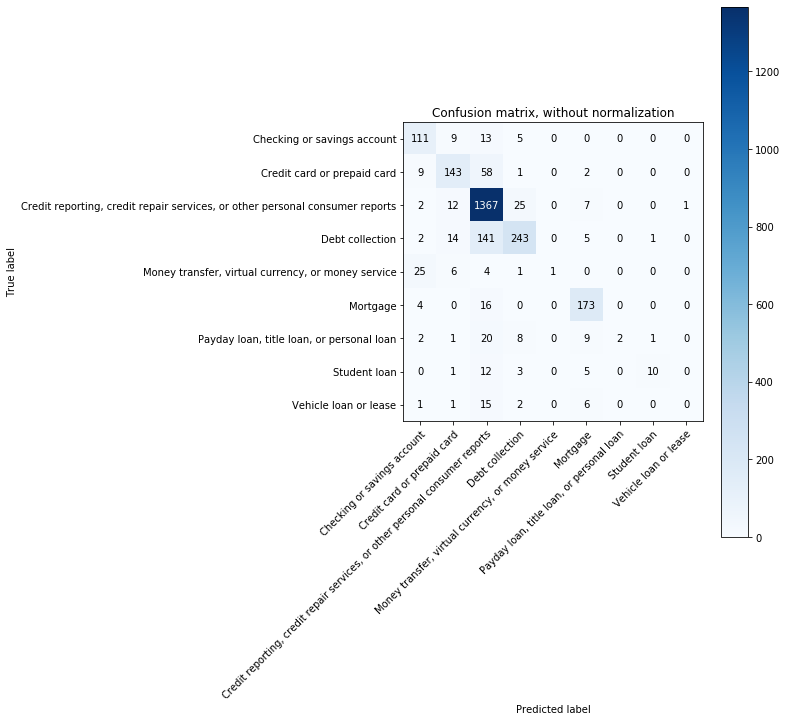

In [50]:
text_clf.fit(X_train, y_train)  
y_pred = text_clf.predict(X_test)


plot_confusion_matrix(y_test, y_pred,targets,
                          normalize=False)
plt.show()

### Bonus bonus material
For doc2vec / gensim approach to the same bank data checkout
https://github.com/susanli2016/NLP-with-Python/blob/master/Doc2Vec%20Consumer%20Complaint_3.ipynb